In [80]:
#!pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cpu.html
#!pip install torch_geometric
#!pip install pyvista
#%pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-2.0.1+cpu.html

In [81]:
import torch
import matplotlib.pyplot as plt
from utils import DelaunayTransform
from torch_geometric.data import Data
import networkx as nx
import pyvista as pv
import numpy as np
torch.__version__

'2.0.1+cu117'

In [82]:
import random
N = 150_000
pos = torch.rand((N, 2))
data = Data(pos=pos, surf=torch.full((N, 1), False))
transform = DelaunayTransform()
data = transform(data)
data.pos = pos

data = torch.load('./sampleData.pth')

def plot_graph(data, l=1, plotter=None):
    c = ['r', 'g', 'b', 'm']
    
    p = pv.Plotter() if plotter is None else plotter
    
    mesh = pv.PolyData()
    if data.pos.shape[1] != 3:
        mesh.points = np.concatenate([data.pos.numpy(), np.full((data.pos.shape[0], 1), l)], axis=1) 
    else:
        mesh.points = data.pos.numpy()
    edges = data.edge_index.t().numpy()
    lines = np.hstack([np.full((edges.shape[0], 1), 2), edges]).ravel()
    mesh.lines = lines
    p.add_mesh(mesh, line_width=1, color=random.choice(c))
    
    if plotter is None:
        p.show()

/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


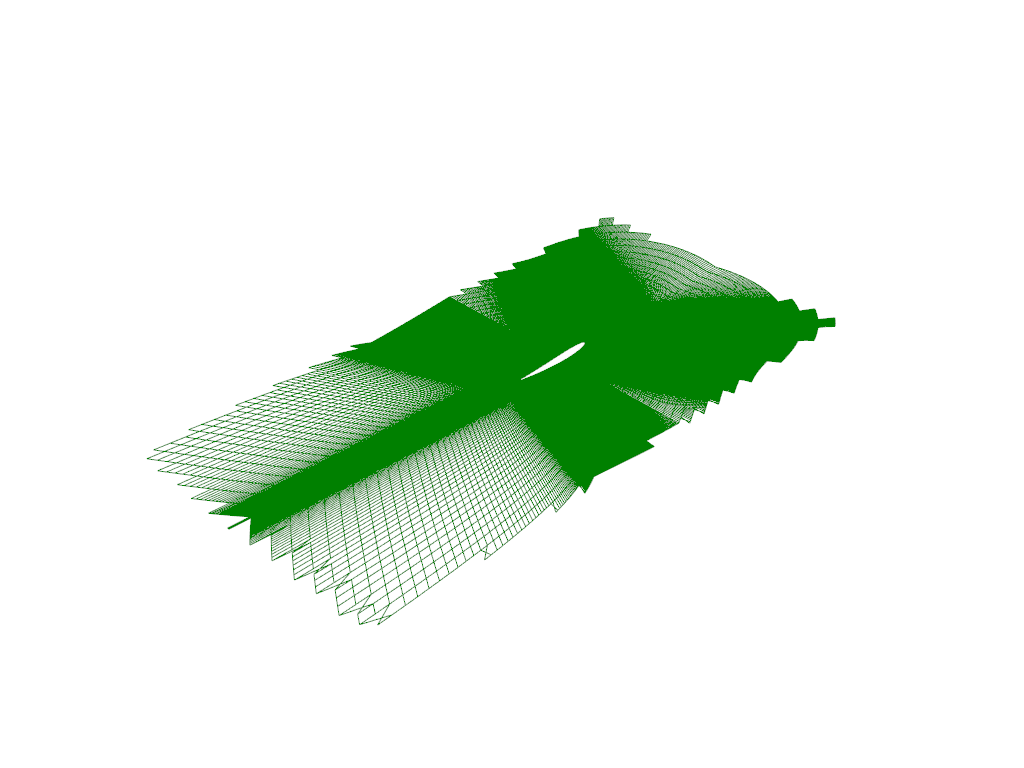

In [83]:
plot_graph(data)

In [84]:
import time

def divide_mesh(v, e, k):
    clusters = [Data(edge_ids=set()) for _ in range(k)]
    
    # Randomly initialize centroids (2D points)
    centroids = torch.rand((k, 2), device=v.device)

    # Precompute edge directions and norms
    edges_directions = v[e[:, 1]] - v[e[:, 0]]
    edges_norms = torch.norm(edges_directions, dim=1, keepdim=True)  # Shape: [num_edges, 1]
    edges_directions /= edges_norms  # Normalize edge directions
    start_all = time.time()
    norm_changes = float('inf')
    while norm_changes > 1e-3:
        # Vectorized clustering step
        centroids_norms = torch.norm(centroids, dim=1, keepdim=True)  # Shape: [num_centroids, 1]
        cosine_angles = torch.matmul(edges_directions, centroids.T) / (centroids_norms.T)  # Shape: [num_edges, num_centroids]
        angles = torch.acos(cosine_angles)  # Ensure values are in valid range for acos
        min_edge_idxs = torch.argmin(angles, dim=1)  # Shape: [num_edges]
        # Efficient assignment to clusters using torch
        cluster_masks = [(min_edge_idxs == i) for i in range(k)]
        for i in range(k):
            clusters[i].edge_ids.update(torch.nonzero(cluster_masks[i]).squeeze(1).tolist())

        # Efficient centroid update
        n_m = 0.0
        for i in range(k):
            if clusters[i].edge_ids:  # Check if the cluster has assigned edges
                cluster_edges = edges_directions[torch.tensor(list(clusters[i].edge_ids), device=v.device)]
                last_centroid = centroids[i].clone()
                centroids[i] = torch.mean(cluster_edges, dim=0)
                n_m = max(torch.norm(centroids[i] - last_centroid), n_m)
        norm_changes = n_m

    print("All:", time.time() - start_all)

    # Post-process clusters to finalize edge indices
    for cluster in clusters:
        cluster.edge_index = e[list(cluster.edge_ids)]
        del cluster.edge_ids

    return clusters


device = torch.device('cpu')
data.pos = data.pos[:, :2].to(device) 
clusters = divide_mesh(data.pos, data.edge_index.T, 8)
clusters

All: 1.2009356021881104


[Data(edge_index=[205070, 2]),
 Data(edge_index=[19358, 2]),
 Data(edge_index=[40048, 2]),
 Data(edge_index=[13995, 2]),
 Data(edge_index=[99363, 2]),
 Data(edge_index=[13628, 2]),
 Data(edge_index=[23959, 2]),
 Data(edge_index=[45581, 2])]

In [85]:
w, h = torch.max(data.pos, dim=0)[0] - torch.min(data.pos, dim=0)[0]
w, h 

(tensor(6.3875), tensor(3.2346))

/home/dimitri/Development/AI/cfdml/env/lib/python3.10/site-packages/pyvista/jupyter/notebook.py:37: UserWarning: Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.
  warnings.warn(


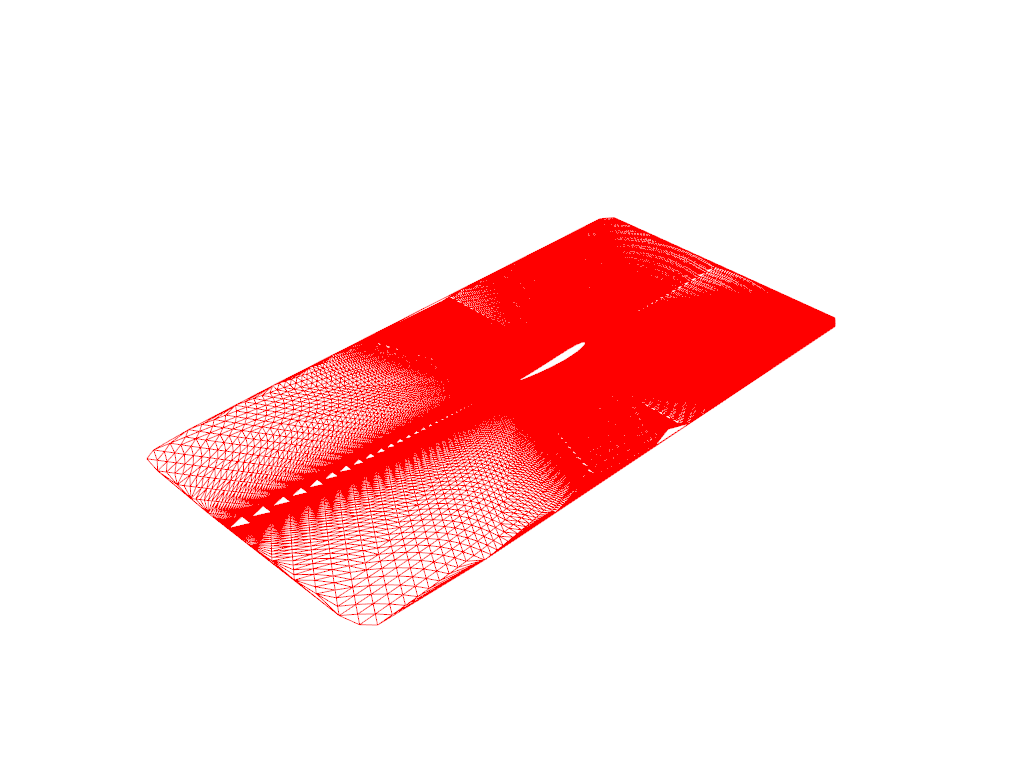

CPU times: user 776 ms, sys: 56.1 ms, total: 832 ms
Wall time: 750 ms


In [106]:
%%time

import torch
from torch_cluster import grid_cluster
from torch_scatter import scatter
def generate_coarse_graph(data, alpha):
    #FIXME: use square grid 
    size = torch.max(data.pos, dim=0)[0] - torch.min(data.pos, dim=0)[0]
    if data.r is None:
        data.r = 200
    r = data.r/alpha
    size /= r
    
    cluster = grid_cluster(data.pos, size) 
    
    unique_indices, new_index = torch.unique(cluster, return_inverse=True)
    out = scatter(data.pos.t(), new_index, reduce='mean')
    
    surf = scatter(data.surf.to(torch.int), new_index, reduce='max')
    edge_index = torch.stack([new_index, torch.arange(0, new_index.shape[0])], dim=0)
    
    return transform(Data(pos=out.t(), surf=surf, r=r))
    
gr = generate_coarse_graph(data)
plot_graph(gr)